# This example notebook, uses the provided OGIP files, to plot the Light Curves


One can follow the tutorial from gammapy here https://docs.gammapy.org/0.19/tutorials/analysis/time/light_curve.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from pathlib import Path

import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from astropy.table import Table

import numpy as np

from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.datasets import Datasets, SpectrumDatasetOnOff

from gammapy.estimators import LightCurveEstimator

# 1. Get the OGIP files and make some selections if need be

In [2]:
base_dir = "/fefs/aswg/workspace/analysis-school-2022/DL3/"
dir_path = "Crab_src_indep/"

ogip_path = Path(base_dir+dir_path+"OGIP/")

# Create the Paths if they do not exist already
ogip_path.mkdir(exist_ok=True)

In [3]:
# read all obs ids of the pha files in the given directory
obs_ids = []
pha_files = list(ogip_path.glob("obs_*_arf.fits.gz"))
    
for p in pha_files:
    run = int(p.name[4:8])
    obs_ids.append(run)
obs_ids = np.sort(np.array(obs_ids))

In [4]:
# Generate the Datasets object back from the OGIP files
datasets = Datasets()
for obs in obs_ids:
    file = ogip_path / f"obs_{obs}.fits.gz"
    datasets.append(SpectrumDatasetOnOff.read(file))

## Read the OGIP files and some metadata stored in it

In [5]:
fits.open(ogip_path / f"obs_{obs_ids[1]}.fits.gz").info()

Filename: /fefs/aswg/workspace/analysis-school-2022/DL3/Crab_src_indep/OGIP/obs_2968.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPECTRUM      1 BinTableHDU     38   19R x 4C   [I, J, L, K]   
  2  EBOUNDS       1 BinTableHDU     26   19R x 3C   [I, D, D]   
  3  REGION        1 BinTableHDU     45   1R x 6C   [D, D, 6A, 4D, K, K]   
  4  GTI           1 BinTableHDU     29   1R x 2C   [D, D]   


In [6]:
Table.read(ogip_path / f"obs_{obs_ids[1]}.fits.gz", hdu="SPECTRUM").meta

OrderedDict([('EXTNAME', 'SPECTRUM'),
             ('TELESCOP', 'unknown'),
             ('INSTRUME', 'unknown'),
             ('FILTER', 'None'),
             ('EXPOSURE', 1137.20611808597),
             ('CORRFILE', ''),
             ('CORRSCAL', ''),
             ('ANCRFILE', 'obs_2968_arf.fits.gz'),
             ('HDUCLASS', 'OGIP'),
             ('HDUCLAS1', 'SPECTRUM'),
             ('HDUVERS', '1.2.1'),
             ('POISSERR', True),
             ('CHANTYPE', 'PHA'),
             ('DETCHANS', 19),
             ('GROUPING', 0),
             ('AREASCAL', 1),
             ('HDUCLAS2', 'TOTAL'),
             ('HDUCLAS3', 'COUNT'),
             ('HDUCLAS4', 'TYPE:1'),
             ('OBS_ID', '2968'),
             ('BACKFILE', 'obs_2968_bkg.fits.gz'),
             ('RESPFILE', 'obs_2968_rmf.fits.gz')])

In [7]:
Table.read(ogip_path / f"obs_{obs_ids[1]}.fits.gz", hdu="REGION").meta

OrderedDict([('WCSAXES', 2),
             ('CRPIX1', 1800.5),
             ('CRPIX2', 900.5),
             ('CDELT1', -0.1),
             ('CDELT2', 0.1),
             ('CUNIT1', 'deg'),
             ('CUNIT2', 'deg'),
             ('CTYPE1', 'RA---TAN'),
             ('CTYPE2', 'DEC--TAN'),
             ('CRVAL1', 83.63308333),
             ('CRVAL2', 22.0145),
             ('LONPOLE', 180.0),
             ('LATPOLE', 22.0145),
             ('MJDREF', 0.0),
             ('RADESYS', 'ICRS'),
             ('WCSSHAPE', '(3600,1800)'),
             ('EXTNAME', 'REGION'),
             ('OBJECT', 'Crab')])

In [8]:
fits.open(ogip_path / f"obs_{obs_ids[1]}_bkg.fits.gz").info()

Filename: /fefs/aswg/workspace/analysis-school-2022/DL3/Crab_src_indep/OGIP/obs_2968_bkg.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPECTRUM      1 BinTableHDU     38   19R x 4C   [I, J, L, K]   
  2  EBOUNDS       1 BinTableHDU     26   19R x 3C   [I, D, D]   
  3  REGION        1 BinTableHDU     44   1R x 6C   [D, D, 6A, 4D, K, K]   


In [9]:
Table.read(ogip_path / f"obs_{obs_ids[1]}_bkg.fits.gz", hdu="SPECTRUM").meta

OrderedDict([('EXTNAME', 'SPECTRUM'),
             ('TELESCOP', 'unknown'),
             ('INSTRUME', 'unknown'),
             ('FILTER', 'None'),
             ('EXPOSURE', 1137.20611808597),
             ('CORRFILE', ''),
             ('CORRSCAL', ''),
             ('ANCRFILE', 'obs_2968_arf.fits.gz'),
             ('HDUCLASS', 'OGIP'),
             ('HDUCLAS1', 'SPECTRUM'),
             ('HDUVERS', '1.2.1'),
             ('POISSERR', True),
             ('CHANTYPE', 'PHA'),
             ('DETCHANS', 19),
             ('GROUPING', 0),
             ('AREASCAL', 1),
             ('HDUCLAS2', 'BKG'),
             ('HDUCLAS3', 'COUNT'),
             ('HDUCLAS4', 'TYPE:1'),
             ('OBS_ID', '2968'),
             ('BACKFILE', 'obs_2968_bkg.fits.gz'),
             ('RESPFILE', 'obs_2968_rmf.fits.gz')])

In [10]:
fits.open(ogip_path / f"obs_{obs_ids[1]}_arf.fits.gz").info()

Filename: /fefs/aswg/workspace/analysis-school-2022/DL3/Crab_src_indep/OGIP/obs_2968_arf.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPECRESP      1 BinTableHDU     25   40R x 3C   [D, D, D]   


In [11]:
Table.read(ogip_path / f"obs_{obs_ids[1]}_arf.fits.gz", hdu="SPECRESP")

ENERG_LO,ENERG_HI,SPECRESP
TeV,TeV,m2
float64,float64,float64
0.010000000000000004,0.012589254117941677,63.40700314598604
0.012589254117941677,0.01584893192461114,322.7464747445423
0.01584893192461114,0.019952623149688802,582.0859463431004
0.019952623149688802,0.02511886431509582,1137.660263524147
0.02511886431509582,0.03162277660168381,1780.3624764647489
0.03162277660168381,0.03981071705534975,3645.623662013372
0.03981071705534975,0.05011872336272727,6222.468008589275
0.05011872336272727,0.06309573444801937,12937.297446757733


In [12]:
fits.open(ogip_path / f"obs_{obs_ids[1]}_rmf.fits.gz").info()

Filename: /fefs/aswg/workspace/analysis-school-2022/DL3/Crab_src_indep/OGIP/obs_2968_rmf.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  MATRIX        1 BinTableHDU     31   40R x 6C   [E, E, I, PI(5), PI(5), PE(12)]   
  2  EBOUNDS       1 BinTableHDU     26   19R x 3C   [I, D, D]   


In [13]:
Table.read(ogip_path / f"obs_{obs_ids[1]}_rmf.fits.gz", hdu="MATRIX")

ENERG_LO,ENERG_HI,N_GRP,F_CHAN,N_CHAN,MATRIX
TeV,TeV,,,,
float32,float32,int16,object,object,object
0.01,0.012589254,4,[ 0 10 13 16],[5 1 2 2],[4.0766637e-17 1.1608712e-01 6.1178356e-01 2.7212933e-01 3.3306691e-16 1.4543922e-14 1.5876189e-14 2.0317081e-14 1.3522516e-13 2.9509728e-13]
0.012589254,0.015848933,1,[0],[5],[0.00246026 0.08069239 0.45363387 0.3970625 0.06615097]
0.015848933,0.019952623,5,[ 0 7 11 13 15],[6 1 1 1 2],[4.6231132e-04 5.8384329e-02 4.1568846e-01 4.0013477e-01 1.2490561e-01 4.2454756e-04 1.5543122e-15 1.7097435e-14 2.9087843e-14 6.7834627e-14 2.3536728e-14]
0.019952623,0.025118865,5,[ 0 8 13 15 17],[7 2 1 1 1],[6.7620154e-04 3.8885526e-02 2.9974499e-01 4.6985328e-01 1.6827162e-01 2.2568386e-02 6.6613381e-16 3.3306691e-15 4.4408921e-16 1.0769163e-14 7.0499162e-14 2.5834890e-13]
0.025118865,0.031622775,1,[1],[6],[0.01528441 0.2387164 0.45635858 0.23983905 0.0487838 0.00101775]
0.031622775,0.039810717,1,[0],[7],[4.5950597e-05 8.9364210e-03 1.2312714e-01 4.2762813e-01 3.4467453e-01 8.6913668e-02 8.6741410e-03]
0.039810717,0.050118722,1,[0],[10],[1.7582128e-05 2.7839690e-03 6.4375289e-02 3.1696880e-01 4.5600775e-01 1.4054219e-01 1.8056044e-02 1.2483725e-03 2.2204460e-15 1.7763568e-15]
0.050118722,0.06309573,1,[0],[9],[9.1975880e-06 8.8620326e-04 2.2375915e-02 1.9449542e-01 5.0154299e-01 2.4091566e-01 3.5224825e-02 4.5497967e-03 3.3306691e-16]


# 2. Get some parameters to use from the datasets

In [14]:
t_start = []
t_stop = []
tot_time = []
obj_name = []

for obs in obs_ids:
    file = ogip_path / f"obs_{obs}.fits.gz"
    t = Table.read(file, hdu="GTI")
    r = Table.read(file, hdu="REGION").meta
    
    t_start.append(t["START"][0])
    t_stop.append(t["STOP"][0])
    tot_time.append(t["STOP"][0] - t["START"][0])
    
    obj_name.append(r["OBJECT"])
print(obs_ids)

t_start = np.sort(np.array(t_start))
t_stop = np.sort(np.array(t_stop))
tot_time = np.array(tot_time)
print(tot_time.sum()/3600)

obj_name = np.unique(np.array(obj_name))[0]

[2967 2968 2969 2970 2971 2972 2973 2974 2975 2976 2977]
3.62014906320307


In [15]:
e_reco_edges = datasets[0].counts.geom.axes["energy"].edges

In [16]:
# Energy range for estimating the Light Curve.
# One can play with different energy bins to check the different LCs

# Using these values to check with Crab reference flux of MAGIC JHEAP 2015
e_fit_min = 0.3 * u.TeV
e_fit_max = 100 * u.TeV

# 3. Get Pivot energy to fix the reference energy and define the Spectrum Model

In [17]:
# Find pivot (decorrelation) energy for a Power Law model to get the reference energy for Log Parabola model
def get_pivot_energy(datasets, e_ref, e_edges, obj_name):
    """
    Using Power Law spectral model with the given reference energy and
    get the decorrelation energy of the fit, within the fit energy range, e_edges
    """
    spectral_model = PowerLawSpectralModel(
        index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=e_ref
    )
    model = SkyModel(spectral_model=spectral_model, name=obj_name)
    model_check = model.copy()

    # Stacked dataset method
    stacked_dataset = Datasets(datasets).stack_reduce()
    stacked_dataset.models = model_check

    fit_stacked = Fit()
    result_stacked = fit_stacked.run(datasets=stacked_dataset)
    
    return model_check.spectral_model.pivot_energy


In [18]:
# Using a reference energy close to the expected decorrelation energy
ref = get_pivot_energy(datasets, 0.4 * u.TeV, e_reco_edges, obj_name)
print(ref.to_value(u.GeV))

475.79579463258864


In [19]:
# Final spectral model of Log Parabola, to be used for estimating the LC.
# One can try different Spectral Models as well.
# Be careful in the choice of Spectral Model being used for the 2 examples presented here

# Using the same values as we get from plotting SED, from the other notebook.
# Crab
spectral_model_lp = LogParabolaSpectralModel(
        amplitude = 1.75e-10 * u.Unit('cm-2 s-1 TeV-1'),
        reference = ref,
        alpha = 2.325 * u.Unit(''),
        beta = 0.0697 * u.Unit('')
)
model_lp = SkyModel(spectral_model=spectral_model_lp, name=obj_name)

In [20]:
# Use the appropriate models, as per the selection of the source/dataset
params=model_lp.to_dict()['spectral']['parameters']
params

[{'name': 'amplitude', 'value': 1.75e-10, 'unit': 'cm-2 s-1 TeV-1'},
 {'name': 'reference',
  'value': 0.47579579463258864,
  'unit': 'TeV',
  'frozen': True},
 {'name': 'alpha', 'value': 2.325},
 {'name': 'beta', 'value': 0.0697}]

# 4. Estimate the LC

In [21]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[e_fit_min, e_fit_max], 
    reoptimize=False, # Re-optimizing other free model parameters (not belonging to the source)
    source=obj_name, 
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)

In [22]:
# Need the time start and end
t_start = Time(t_start, format='unix')
t_stop = Time(t_stop, format='unix')

t_day = np.unique(np.rint(t_start.mjd))

# To make the range night-wise, keep the MJD range in half integral values
t_range = [Time([t-0.5, t+0.5], format="mjd", scale="utc") for t in t_day]

lc_maker_night_wise = LightCurveEstimator(
    energy_edges=[e_fit_min, e_fit_max], 
    time_intervals=t_range,
    reoptimize=False, 
    source=obj_name,
    selection_optional="all"
)

In [23]:
# Assigning the model for each dataset
for data in datasets:
    data.models = model_lp

lc_1d = lc_maker_1d.run(datasets)
lc_night = lc_maker_night_wise.run(datasets)

In [24]:
# Check the various column data of the Light Curve object
lc_1d.to_table(sed_type="flux", format="lightcurve")

time_min,time_max,e_ref [1],e_min [1],e_max [1],flux [1],flux_err [1],flux_errp [1],flux_errn [1],flux_ul [1],ts [1],sqrt_ts [1],"npred [1,11]","npred_excess [1,11]",stat [1],is_ul [1],"counts [1,11]",success [1],"norm_scan [1,11]","stat_scan [1,11]"
,,TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,bool,float64,float64
59174.01970061281,59174.03356212063,3.6254207399646123,0.32859188854413895,40.0,1.1160402261100464e-10,9.336329845170476e-12,9.397999119494703e-12,9.27515131232602e-12,1.3051605581833935e-10,146.36651864885195,12.098203116531478,481.85477762308057 .. nan,300.7205505371094 .. nan,11.026053555275455,False,477.0 .. nan,True,0.2 .. 4.999999999999999,112.10813353714337 .. 916.2117037040198
59174.03458026783,59174.04829881451,3.6254207399646123,0.32859188854413895,40.0,1.1535268934985908e-10,9.122470683690817e-12,9.211386337297716e-12,9.03738073728094e-12,1.3396074740760632e-10,171.38449248778787,13.091390013584801,nan .. nan,nan .. nan,6.174779802273332,False,nan .. nan,True,0.2 .. 4.999999999999999,126.61409840452191 .. 891.2920745345148
59174.04913458202,59174.062836007324,3.6254207399646123,0.32859188854413895,40.0,1.0405791673710491e-10,9.004921426368216e-12,9.07686944941766e-12,8.943843098417602e-12,1.224397367559429e-10,137.32679020689392,11.71865138174585,nan .. nan,nan .. nan,19.033049279785743,False,nan .. nan,True,0.2 .. 4.999999999999999,110.8907906726669 .. 975.5050338119838
59174.06372647877,59174.07741072641,3.6254207399646123,0.32859188854413895,40.0,9.377684783028222e-11,8.974640926222677e-12,9.081710027429617e-12,8.866549720405009e-12,1.1215249854667036e-10,103.5857852432957,10.177710216119129,nan .. nan,nan .. nan,16.649394109911885,False,nan .. nan,True,0.2 .. 4.999999999999999,83.1958078775222 .. 987.0157273194475
59174.07831871167,59174.09210337368,3.6254207399646123,0.32859188854413895,40.0,9.711569464450751e-11,8.798161245835126e-12,8.89534420280601e-12,8.703706492105634e-12,1.1511080847666606e-10,132.18170332728192,11.497030195980262,nan .. nan,nan .. nan,3.1820077097463244,False,nan .. nan,True,0.2 .. 4.999999999999999,89.9076389018422 .. 985.8874574455388
59174.09287601319,59174.10661263799,3.6254207399646123,0.32859188854413895,40.0,1.0377537445143098e-10,9.279010951897971e-12,9.376352606706957e-12,9.183689548001638e-12,1.2272812480805695e-10,137.60165116434013,11.730373018976852,nan .. nan,nan .. nan,13.207479030951843,False,nan .. nan,True,0.2 .. 4.999999999999999,104.86209558089269 .. 921.0109605041064
59174.10755984179,59174.12127623159,3.6254207399646123,0.32859188854413895,40.0,9.247942816268829e-11,8.882527618800154e-12,8.975808140901312e-12,8.790842669618357e-12,1.10618790652112e-10,108.67358426938179,10.42466230960897,nan .. nan,nan .. nan,5.271350722065299,False,nan .. nan,True,0.2 .. 4.999999999999999,74.16091700918707 .. 1005.2971399996472
59174.12211270787,59174.13590920742,3.6254207399646123,0.32859188854413895,40.0,7.931790332431868e-11,8.69502992658847e-12,8.773452623330612e-12,8.622747976741169e-12,9.703386985353146e-11,88.15809417061025,9.389254186068788,nan .. nan,nan .. nan,10.525380722627606,False,nan .. nan,True,0.2 .. 4.999999999999999,61.05404854609784 .. 1083.201714307384


In [25]:
# If there are more than 1 night of data, one can see the integrated light curve for each night
lc_night.to_table(sed_type="flux", format="lightcurve")

time_min,time_max,e_ref [1],e_min [1],e_max [1],flux [1],flux_err [1],flux_errp [1],flux_errn [1],flux_ul [1],ts [1],sqrt_ts [1],"npred [1,11]","npred_excess [1,11]",stat [1],is_ul [1],"counts [1,11]",success [1],"norm_scan [1,11]","stat_scan [1,11]"
,,TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,bool,float64,float64
59173.50080074074,59174.50080074074,3.6254207399646123,0.32859188854413895,40.0,9.850053548655774e-11,2.728733822435559e-12,2.7362030213745862e-12,2.721373125434961e-12,1.0398816005393912e-10,1366.31638107646,36.96371708955229,456.5964168914928 .. 458.2324465544902,265.41278076171875 .. 260.7059326171875,117.93038384472474,False,477.0 .. 458.0,True,0.2 .. 4.999999999999999,1009.6006941412489 .. 10700.474751619859


# 5. Plot the Light Curve

In [26]:
# Calculate & plot Crab reference flux
# https://doi.org/10.1016/j.jheap.2015.01.002
crab = create_crab_spectral_model("magic_lp")
crab.amplitude.error = 0.03e-11 * u.Unit("cm-2 s-1 TeV-1")
crab.alpha.error = 0.01
crab.beta.error = 0.01/np.log(10)

flux_crab, flux_crab_error = crab.integral_error(e_fit_min, e_fit_max)
print(flux_crab, flux_crab_error)

1.1988092745620748e-10 1 / (cm2 s) 1.3284263540422391e-12 1 / (cm2 s)


/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


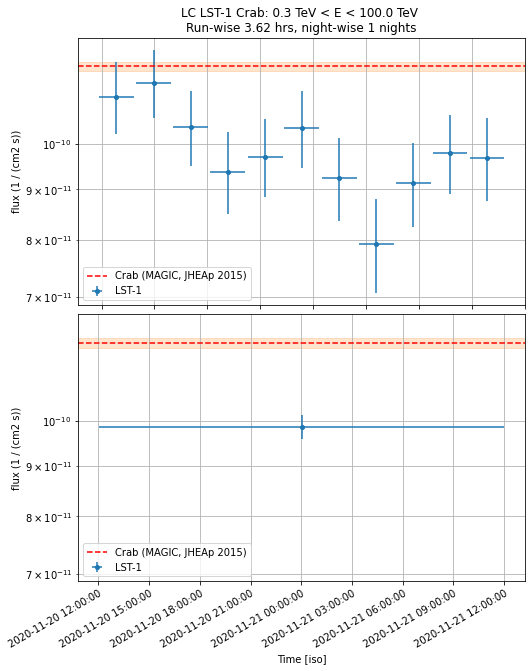

In [27]:
fig_lc = plt.figure(figsize=(8,10))

gs2 = GridSpec(10, 5)

gs2.update(wspace=0.4)
args1 = [gs2[:5,:]]
args2 = [gs2[5:,:]]

fig_gs1 = fig_lc.add_subplot(*args1)
fig_gs2 = fig_lc.add_subplot(*args2, sharey=fig_gs1)

lc_1d.plot(
    ax=fig_gs1,
    sed_type="flux",
    marker="o", label="LST-1"
)
fig_gs1.axhline(
    flux_crab.to_value("cm-2 s-1"), c='red', ls='--', 
    label='Crab (MAGIC, JHEAp 2015)'
)
fig_gs1.axhspan(
    (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
    (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
    alpha=0.2, color='tab:orange'
)
fig_gs1.get_xaxis().set_ticklabels([])
fig_gs1.grid(which='both')
fig_gs1.set_title(
    f'LC LST-1 {obj_name}: {e_fit_min} < E < {e_fit_max} \nRun-wise {tot_time.sum()/3600:.2f} hrs, night-wise {len(t_day)} nights'
)
fig_gs1.legend()
fig_gs1.get_yaxis().get_offset_text().set_position((-0.06,1))

lc_night.plot(
    ax=fig_gs2,
    sed_type="flux",
    axis_name="time",
    marker="o", label="LST-1"
)
fig_gs2.axhline(
    flux_crab.to_value("cm-2 s-1"), c='red', ls='--', 
    label='Crab (MAGIC, JHEAp 2015)'
)
fig_gs2.axhspan(
    (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
    (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
    alpha=0.2, color='tab:orange'
)

fig_gs2.grid(which='both')
fig_gs2.legend()